In [16]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image
from PIL import UnidentifiedImageError
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import os

%matplotlib inline

c:\Users\Lautaro\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


n_cats: 12495  n_dogs: 12497


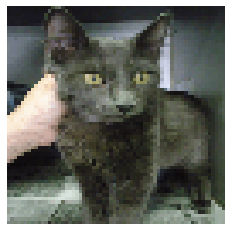

In [45]:
path = 'C:\\Users\\Lautaro\\Desktop\\Lautaro\\asd\\2021\\Doctorado\\Materias\\Deep Learning (2020)\\Datasets\\CatsvDogs'

cats = os.path.join(path, 'Cat')
dogs = os.path.join(path, 'Dog')

data = []

for cat in os.listdir(cats):
    try:
        curr_img = image.imread(os.path.join(cats, cat))
        res_img = resize(curr_img, (64, 64), anti_aliasing=0)
        shape = res_img.shape
        if shape == (64,64,3):
            data.append(res_img)

        #A veces la imagen se lee con un 4to canal lleno de unos, lo saco
        elif shape == (64,64,4):
            data.append(res_img[...,:3])

    except UnidentifiedImageError:
        pass

n_cats = len(data)
y = np.zeros((n_cats))

for dog in os.listdir(dogs):
    try:
        curr_img = image.imread(os.path.join(dogs, dog))
        res_img = resize(curr_img, (64, 64), anti_aliasing=0)
        shape = res_img.shape
        if shape == (64,64,3):
            data.append(res_img)
        elif shape == (64,64,4):
            data.append(res_img[...,:3])
          
    except UnidentifiedImageError:
        pass
        

n_dogs = len(data) - n_cats
y = np.append(y, np.ones((n_dogs)))


print('n_cats:', n_cats, ' n_dogs:', n_dogs)
plt.imshow(data[143])
plt.axis('off');

In [47]:
data = np.stack(data, axis=0)

df = np.stack((data, y))
df.shape

ValueError: all input arrays must have the same shape

In [40]:
for i in range(len(data)):
    if data[i].shape == (64,64,4):
        data[i] = data[i][:,:,:3]

In [ ]:
#Aumentacion de datos
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=(-0.2, 0.2)),
        keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), 
                                       width_factor=(-0.2, 0.2)),
    ]
)

# Create a tf.data pipeline of augmented images (and their labels)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(256).map(lambda x, y: (data_augmentation(x), y))

In [ ]:
def plot(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    ax1.plot(hist.history['loss'], label='CCE')
    ax1.plot(hist.history['val_loss'], label='val_CCE')
    ax1.set_xlabel('Epocas', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.legend(loc='best')

    ax2.plot(hist.history['sparse_categorical_accuracy'], label='acc')
    ax2.plot(hist.history['val_sparse_categorical_accuracy'], label='val_acc')
    ax2.set_xlabel('Epocas', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.legend(loc='best')

    fig.tight_layout()
    plt.show()
    return None

In [ ]:
keras.backend.clear_session()

reg = keras.regularizers.L2(l2=1e-3)
drop_r = 0.4

model = keras.models.Sequential(name='AlexNet')

#Capas convolucionales

model.add(keras.layers.Input(shape=(32,32,3)))
model.add(keras.layers.Rescaling(1.0 / 255))

model.add(keras.layers.Conv2D(128, 5, strides=1, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=1))

model.add(keras.layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2))

model.add(keras.layers.Conv2D(352, 3, strides=2, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(352, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(256, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=drop_r))


#Capas densas

model.add(keras.layers.Dense(2048, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(rate=drop_r))
model.add(keras.layers.Dense(2048, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(rate=drop_r))
model.add(keras.layers.Dense(10, activation='softmax', kernel_regularizer=reg))

model.summary()

In [ ]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

def scheduler(epoch, lr):
  if epoch==10 or epoch == 25 or epoch == 50 or epoch == 75:
    return lr/3
  else:
    return lr


callbacks_list=[
    keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0
    ),
    ClearMemory()
]

In [ ]:
opt = keras.optimizers.Adam(learning_rate=.0003)


model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

hist = model.fit(train_dataset, validation_data=(x_test, y_test), 
                 callbacks=callbacks_list, epochs=100, verbose=1)